# Setup

In [1]:
# import your standard packages
%run ../pkgs.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Parameters and Paths

In [2]:
inpath = "/tigress/GEOCLIM/LRGROUP/shared_data/woa18/"
outfn = '../../data/woa_processed.nc'

# total
lat_bounds = [-1.5, 33]
lon_bounds = [48.5, 102.5]

# regional 
bounds_wAS = [51.125,66,12.5,28]
bounds_eAS = [66,79,3,28]
bounds_wBoB = [79,87,2,28]
bounds_eBoB = [87,103,0,28]

# Get Data

In [3]:
for tt in tqdm(range(1,13)):
     
    if tt < 10:
        t='0'+str(tt)
    else:
        t=str(tt)
        
    if tt == 1:
        data=xr.open_dataset(inpath+"temp/1deg/monthly/woa18_decav_t"+t+"_01.nc", decode_times=False)
        
        DEPTH = data.depth
        
        
        TEMP = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        DOXY = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        SAL = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        NITRATE = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        PHOSPHATE = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
       
        
    # TEMP
    data=xr.open_dataset(inpath+"temp/1deg/monthly/woa18_decav_t"+t+"_01.nc", decode_times=False)
    TEMP[tt-1,:,:,:] = np.array(data["t_an"][0,:,:,:])
    
    # SAL
    data=xr.open_dataset(inpath+"salt/1deg/monthly/woa18_decav_s"+t+"_01.nc", decode_times=False)
    SAL[tt-1,:,:,:] = np.array(data["s_an"][0,:,:,:])
    
    # DOXY
    data=xr.open_dataset(inpath+"oxygen/monthly/woa18_all_o"+t+"_01.nc", decode_times=False)
    DOXY[tt-1,:,:,:] = np.array(data["o_an"][0,:,:,:])
    
    # Nitrate
    data=xr.open_dataset(inpath+"nitrate/monthly/woa18_all_n"+t+"_01.nc", decode_times=False)
    NITRATE[tt-1,:43,:,:] = np.array(data["n_an"][0,:,:,:])
    
    # Phosphate
    data=xr.open_dataset(inpath+"phosphate/monthly/woa18_all_p"+t+"_01.nc", decode_times=False)
    PHOSPHATE[tt-1,:43,:,:] = np.array(data["p_an"][0,:,:,:])
    
# depth to pressure
LAT = np.array(data.lat)
LON = np.array(data.lon)

# PRES = np.full([len(DEPTH),len(LAT),len(LON)],np.nan)

# for ii,tmplat in zip(range(len(LAT)),LAT):
#     for jj in range(len(lon)):
#         PRES[:,ii,jj]=sw.eos80.pres(DEPTH, [tmplat for i in range(len(DEPTH))])


100%|██████████| 12/12 [00:09<00:00,  1.38it/s]


# Subset

In [4]:
ds_full = xr.Dataset(coords={'month': np.arange(1,13),
                        'depth': DEPTH,
                        'lon': LON,
                        'lat': LAT})

coords = [np.arange(1,13),DEPTH,LAT,LON]
dims = ['month','depth','lat','lon']

# add to dataset
ds_full['temp'] = xr.DataArray(TEMP,dims = dims,coords = coords)
ds_full['sal'] = xr.DataArray(SAL,dims = dims,coords = coords)
ds_full['doxy'] = xr.DataArray(DOXY,dims = dims,coords = coords)
ds_full['nitrate'] = xr.DataArray(NITRATE,dims = dims,coords = coords)
ds_full['phosphate'] = xr.DataArray(PHOSPHATE,dims = dims,coords = coords)


# subset
lat_slice = slice(lat_bounds[0], lat_bounds[1])
lon_slice = slice(lon_bounds[0], lon_bounds[1])

ds_full = ds_full.sel(lat = lat_slice, lon = lon_slice)
ds_full

<xarray.Dataset>
Dimensions:    (depth: 57, lat: 35, lon: 55, month: 12)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth      (depth) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, depth, lat, lon) float64 27.04 27.16 27.28 ... nan nan
    sal        (month, depth, lat, lon) float64 35.32 35.32 35.32 ... nan nan
    doxy       (month, depth, lat, lon) float64 208.9 209.1 208.3 ... nan nan
    nitrate    (month, depth, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, depth, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

# Interpolate to Standard Pressure Levels

In [7]:
PRES_i = np.array(ds_full.depth)

n = ds_full.lat.shape[0]
m = ds_full.lon.shape[0]
t = 12
d = ds_full.depth.shape[0]
with tqdm(total=n * m * t) as pbar:
    for tt in range(12):
        
        if tt == 0:
            TEMP_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            DOXY_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            SAL_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            NITRATE_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            PHOSPHATE_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
                    
        for ii,lat in zip(range(n),ds_full.lat):
            for jj in range(m):

                # conversion [m] -> [dbar]:
#                 pres=sw.eos80.pres(ds_full.depth, [lat for i in range(d)])
                pres = gsw.p_from_z(-1*ds_full.depth, [lat for i in range(d)])

                # temp,psal,doxy selection
                temp,sal,doxy = ds_full.temp[tt,:,ii,jj],ds_full.sal[tt,:,ii,jj],ds_full.doxy[tt,:,ii,jj]
                nitrate,phosphate = ds_full.nitrate[tt,:,ii,jj],ds_full.phosphate[tt,:,ii,jj]

                # interpolation
                ft = sp.interp1d(pres,temp,bounds_error=False,fill_value=np.nan)
                TEMP_i[tt,:,ii,jj] = ft(PRES_i)
                    
                fo = sp.interp1d(pres,doxy,bounds_error=False,fill_value=np.nan)
                DOXY_i[tt,:,ii,jj] = fo(PRES_i)
                
                fs = sp.interp1d(pres,sal,bounds_error=False,fill_value=np.nan)
                SAL_i[tt,:,ii,jj] = fs(PRES_i)
                
                fn = sp.interp1d(pres,nitrate,bounds_error=False,fill_value=np.nan)
                NITRATE_i[tt,:,ii,jj] = fn(PRES_i)
                
                fp = sp.interp1d(pres,phosphate,bounds_error=False,fill_value=np.nan)
                PHOSPHATE_i[tt,:,ii,jj] = fp(PRES_i)
                
                pbar.update(1)
            
            
ds_out=xr.Dataset(coords={'month': np.arange(1,13),
                        'pres': PRES_i,
                        'lon': ds_full.lon,
                        'lat': ds_full.lat})
# add to dataset
ds_out['temp'] = xr.DataArray(TEMP_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['sal'] = xr.DataArray(SAL_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['doxy'] = xr.DataArray(DOXY_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['nitrate'] = xr.DataArray(NITRATE_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['phosphate'] = xr.DataArray(PHOSPHATE_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out         

100%|██████████| 23100/23100 [01:50<00:00, 209.16it/s]


<xarray.Dataset>
Dimensions:    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, pres, lat, lon) float64 27.04 27.16 27.28 ... nan nan nan
    sal        (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan
    doxy       (month, pres, lat, lon) float64 208.9 209.1 208.3 ... nan nan nan
    nitrate    (month, pres, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, pres, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

In [8]:
ds_out

<xarray.Dataset>
Dimensions:    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, pres, lat, lon) float64 27.04 27.16 27.28 ... nan nan nan
    sal        (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan
    doxy       (month, pres, lat, lon) float64 208.9 209.1 208.3 ... nan nan nan
    nitrate    (month, pres, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, pres, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

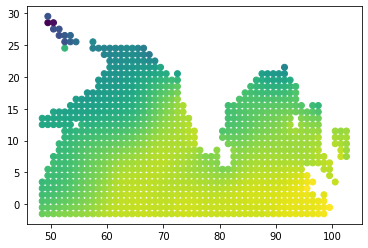

In [9]:
xx,yy = np.meshgrid(ds_out.lon,ds_out.lat)
plt.scatter(xx.flatten(),yy.flatten(), c = np.array(ds_out.temp[0,0,:,:]).flatten())

<xarray.Dataset>
Dimensions:    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, pres, lat, lon) float64 27.04 27.16 27.28 ... nan nan nan
    sal        (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan
    doxy       (month, pres, lat, lon) float64 208.9 209.1 208.3 ... nan nan nan
    nitrate    (month, pres, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, pres, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

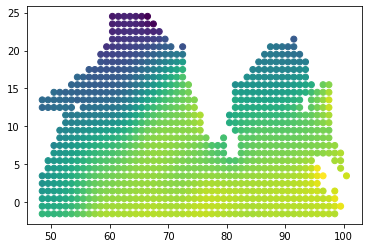

In [10]:
temp = ds_out.temp.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
sal = ds_out.sal.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
doxy = ds_out.doxy.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
nitrate = ds_out.nitrate.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
phosphate = ds_out.phosphate.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))

temp = temp.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
sal = sal.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
doxy = doxy.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
nitrate = nitrate.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
phosphate = phosphate.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))

xx,yy = np.meshgrid(temp.lon,temp.lat)
plt.scatter(xx.flatten(),yy.flatten(), c = np.array(temp[1,0,:,:]).flatten())

lat = temp.lat
lon = temp.lon
pres = temp.pres

# add to dataset
ds_out['temp'] = xr.DataArray(temp,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['sal'] = xr.DataArray(sal,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['doxy'] = xr.DataArray(doxy,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['nitrate'] = xr.DataArray(nitrate,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['phosphate'] = xr.DataArray(phosphate,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out   

# Make sure there aren't any negative concentration values

In [11]:
tmp = np.array(ds_out.doxy)
np.nansum(tmp[tmp <= 0])

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


0.0

In [12]:
# set negative oxygen values to nan
ds_out['doxy'] = ds_out.doxy.where(ds_out.doxy >= 0)
ds_out['nitrate'] = ds_out.nitrate.where(ds_out.nitrate >= 0)
ds_out['phosphate'] = ds_out.phosphate.where(ds_out.phosphate >= 0)

# Find Water Column Averages

In [13]:
# total mean
ind = (ds_out.pres >= 40) & (ds_out.pres <= 200)
doxy_40_200 = np.nanmean(ds_out.doxy[:,ind,:,:],1)
temp_40_200 = np.nanmean(ds_out.temp[:,ind,:,:],1)
sal_40_200 = np.nanmean(ds_out.sal[:,ind,:,:],1)
nitrate_40_200 = np.nanmean(ds_out.nitrate[:,ind,:,:],1)
phosphate_40_200 = np.nanmean(ds_out.phosphate[:,ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 200)
doxy_50_200 = np.nanmean(ds_out.doxy[:,ind,:,:],1)
temp_50_200 = np.nanmean(ds_out.temp[:,ind,:,:],1)
sal_50_200 = np.nanmean(ds_out.sal[:,ind,:,:],1)
nitrate_50_200 = np.nanmean(ds_out.nitrate[:,ind,:,:],1)
phosphate_50_200 = np.nanmean(ds_out.phosphate[:,ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 225)
doxy_50_225 = np.nanmean(ds_out.doxy[:,ind,:,:],1)
temp_50_225 = np.nanmean(ds_out.temp[:,ind,:,:],1)
sal_50_225 = np.nanmean(ds_out.sal[:,ind,:,:],1)
nitrate_50_225 = np.nanmean(ds_out.nitrate[:,ind,:,:],1)
phosphate_50_225 = np.nanmean(ds_out.phosphate[:,ind,:,:],1)

# annual mean
ind = (ds_out.pres >= 40) & (ds_out.pres <= 200)
doxy_40_200_ann_mean = np.nanmean(np.nanmean(ds_out.doxy,0)[ind,:,:],0)
temp_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.temp,0)[ind,:,:],0)
sal_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.sal,0)[ind,:,:],0)
nitrate_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.nitrate,0)[ind,:,:],0)
phosphate_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.phosphate,0)[ind,:,:],0)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 200)
doxy_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.doxy,0)[ind,:,:],0)
temp_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.temp,0)[ind,:,:],0)
sal_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.sal,0)[ind,:,:],0)
nitrate_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.nitrate,0)[ind,:,:],0)
phosphate_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.phosphate,0)[ind,:,:],0)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 225)
doxy_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.doxy,0)[ind,:,:],0)
temp_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.temp,0)[ind,:,:],0)
sal_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.sal,0)[ind,:,:],0)
nitrate_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.nitrate,0)[ind,:,:],0)
phosphate_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.phosphate,0)[ind,:,:],0)

# mean anomaly to 200dbar
ind = (ds_out.pres >= 40) & (ds_out.pres <= 200)
doxy_40_200_anom = np.nanmean(ds_out.doxy[:,ind,:,:] - np.nanmean(ds_out.doxy,0)[ind,:,:],1)
temp_40_200_anom = np.nanmean(ds_out.temp[:,ind,:,:] - np.nanmean(ds_out.temp,0)[ind,:,:],1)
sal_40_200_anom = np.nanmean(ds_out.sal[:,ind,:,:] - np.nanmean(ds_out.sal,0)[ind,:,:],1)
nitrate_40_200_anom = np.nanmean(ds_out.nitrate[:,ind,:,:] - np.nanmean(ds_out.nitrate,0)[ind,:,:],1)
phosphate_40_200_anom = np.nanmean(ds_out.phosphate[:,ind,:,:] - np.nanmean(ds_out.phosphate,0)[ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 200)
doxy_50_200_anom = np.nanmean(ds_out.doxy[:,ind,:,:] - np.nanmean(ds_out.doxy,0)[ind,:,:],1)
temp_50_200_anom = np.nanmean(ds_out.temp[:,ind,:,:] - np.nanmean(ds_out.temp,0)[ind,:,:],1)
sal_50_200_anom = np.nanmean(ds_out.sal[:,ind,:,:] - np.nanmean(ds_out.sal,0)[ind,:,:],1)
nitrate_50_200_anom = np.nanmean(ds_out.nitrate[:,ind,:,:] - np.nanmean(ds_out.nitrate,0)[ind,:,:],1)
phosphate_50_200_anom = np.nanmean(ds_out.phosphate[:,ind,:,:] - np.nanmean(ds_out.phosphate,0)[ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 225)
doxy_50_225_anom = np.nanmean(ds_out.doxy[:,ind,:,:] - np.nanmean(ds_out.doxy,0)[ind,:,:],1)
temp_50_225_anom = np.nanmean(ds_out.temp[:,ind,:,:] - np.nanmean(ds_out.temp,0)[ind,:,:],1)
sal_50_225_anom = np.nanmean(ds_out.sal[:,ind,:,:] - np.nanmean(ds_out.sal,0)[ind,:,:],1)
nitrate_50_225_anom = np.nanmean(ds_out.nitrate[:,ind,:,:] - np.nanmean(ds_out.nitrate,0)[ind,:,:],1)
phosphate_50_225_anom = np.nanmean(ds_out.phosphate[:,ind,:,:] - np.nanmean(ds_out.phosphate,0)[ind,:,:],1)


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is adde

In [14]:
# add to dataset

#------------------------------ profiles -------------------------------------#
coords = [ds_out.month,ds_out.lat,ds_out.lon]
dims = ['month','lat', 'lon']

ds_out['temp_40_200'] = xr.DataArray(temp_40_200,dims = dims,coords = coords)
ds_out['doxy_40_200'] = xr.DataArray(doxy_40_200,dims = dims,coords = coords)
ds_out['sal_40_200'] = xr.DataArray(sal_40_200,dims = dims,coords = coords)
ds_out['nitrate_40_200'] = xr.DataArray(nitrate_40_200,dims = dims,coords = coords)
ds_out['phosphate_40_200'] = xr.DataArray(phosphate_40_200,dims = dims,coords = coords)

ds_out['temp_50_200'] = xr.DataArray(temp_50_200,dims = dims,coords = coords)
ds_out['doxy_50_200'] = xr.DataArray(doxy_50_200,dims = dims,coords = coords)
ds_out['sal_50_200'] = xr.DataArray(sal_50_200,dims = dims,coords = coords)
ds_out['nitrate_50_200'] = xr.DataArray(nitrate_50_200,dims = dims,coords = coords)
ds_out['phosphate_50_200'] = xr.DataArray(phosphate_50_200,dims = dims,coords = coords)

ds_out['temp_50_225'] = xr.DataArray(temp_50_225,dims = dims,coords = coords)
ds_out['doxy_50_225'] = xr.DataArray(doxy_50_225,dims = dims,coords = coords)
ds_out['sal_50_225'] = xr.DataArray(sal_50_225,dims = dims,coords = coords)
ds_out['nitrate_50_225'] = xr.DataArray(nitrate_50_225,dims = dims,coords = coords)
ds_out['phosphate_50_225'] = xr.DataArray(phosphate_50_225,dims = dims,coords = coords)

#------------------------------ annual mean -----------------------------------#
coords = [ds_out.lat,ds_out.lon]
dims = ['lat', 'lon']

ds_out['temp_40_200_ann_mean'] = xr.DataArray(temp_40_200_ann_mean,dims = dims,coords = coords)
ds_out['doxy_40_200_ann_mean'] = xr.DataArray(doxy_40_200_ann_mean,dims = dims,coords = coords)
ds_out['sal_40_200_ann_mean'] = xr.DataArray(sal_40_200_ann_mean,dims = dims,coords = coords)
ds_out['nitrate_40_200_ann_mean'] = xr.DataArray(nitrate_40_200_ann_mean,dims = dims,coords = coords)
ds_out['phosphate_40_200_ann_mean'] = xr.DataArray(phosphate_40_200_ann_mean,dims = dims,coords = coords)

ds_out['temp_50_200_ann_mean'] = xr.DataArray(temp_50_200_ann_mean,dims = dims,coords = coords)
ds_out['doxy_50_200_ann_mean'] = xr.DataArray(doxy_50_200_ann_mean,dims = dims,coords = coords)
ds_out['sal_50_200_ann_mean'] = xr.DataArray(sal_50_200_ann_mean,dims = dims,coords = coords)
ds_out['nitrate_50_200_ann_mean'] = xr.DataArray(nitrate_50_200_ann_mean,dims = dims,coords = coords)
ds_out['phosphate_50_200_ann_mean'] = xr.DataArray(phosphate_50_200_ann_mean,dims = dims,coords = coords)

ds_out['temp_50_225_ann_mean'] = xr.DataArray(temp_50_225_ann_mean,dims = dims,coords = coords)
ds_out['doxy_50_225_ann_mean'] = xr.DataArray(doxy_50_225_ann_mean,dims = dims,coords = coords)
ds_out['sal_50_225_ann_mean'] = xr.DataArray(sal_50_225_ann_mean,dims = dims,coords = coords)
ds_out['nitrate_50_225_ann_mean'] = xr.DataArray(nitrate_50_225_ann_mean,dims = dims,coords = coords)
ds_out['phosphate_50_225_ann_mean'] = xr.DataArray(phosphate_50_225_ann_mean,dims = dims,coords = coords)

#---------------------------- monthly anomaly ---------------------------------#
coords = [ds_out.month,ds_out.lat,ds_out.lon]
dims = ['month','lat', 'lon']

ds_out['temp_40_200_anom'] = xr.DataArray(temp_40_200_anom,dims = dims,coords = coords)
ds_out['doxy_40_200_anom'] = xr.DataArray(doxy_40_200_anom,dims = dims,coords = coords)
ds_out['sal_40_200_anom'] = xr.DataArray(sal_40_200_anom,dims = dims,coords = coords)
ds_out['nitrate_40_200_anom'] = xr.DataArray(nitrate_40_200_anom,dims = dims,coords = coords)
ds_out['phosphate_40_200_anom'] = xr.DataArray(phosphate_40_200_anom,dims = dims,coords = coords)

ds_out['temp_50_200_anom'] = xr.DataArray(temp_50_200_anom,dims = dims,coords = coords)
ds_out['doxy_50_200_anom'] = xr.DataArray(doxy_50_200_anom,dims = dims,coords = coords)
ds_out['sal_50_200_anom'] = xr.DataArray(sal_50_200_anom,dims = dims,coords = coords)
ds_out['nitrate_50_200_anom'] = xr.DataArray(nitrate_50_200_anom,dims = dims,coords = coords)
ds_out['phosphate_50_200_anom'] = xr.DataArray(phosphate_50_200_anom,dims = dims,coords = coords)

ds_out['temp_50_225_anom'] = xr.DataArray(temp_50_225_anom,dims = dims,coords = coords)
ds_out['doxy_50_225_anom'] = xr.DataArray(doxy_50_225_anom,dims = dims,coords = coords)
ds_out['sal_50_225_anom'] = xr.DataArray(sal_50_225_anom,dims = dims,coords = coords)
ds_out['nitrate_50_225_anom'] = xr.DataArray(nitrate_50_225_anom,dims = dims,coords = coords)
ds_out['phosphate_50_225_anom'] = xr.DataArray(phosphate_50_225_anom,dims = dims,coords = coords)

ds_out

<xarray.Dataset>
Dimensions:                    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month                      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres                       (pres) float32 0.0 5.0 10.0 ... 1450.0 1500.0
  * lon                        (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                        (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
Data variables:
    temp                       (month, pres, lat, lon) float64 27.04 ... nan
    sal                        (month, pres, lat, lon) float64 35.32 ... nan
    doxy                       (month, pres, lat, lon) float64 208.9 ... nan
    nitrate                    (month, pres, lat, lon) float64 0.7416 ... nan
    phosphate                  (month, pres, lat, lon) float64 0.1886 ... nan
    temp_40_200                (month, lat, lon) float64 22.35 22.06 ... nan nan
    doxy_40_200                (month, lat, lon) float64 167.9 165.3 ... nan nan
    sal_40_200                 

# SAVE

In [15]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")